╔══<i><b>Alai-DeepLearning</b></i>════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 11. CNN Architectures**
# Section 3. CIFAR-100을 이용한 GoogLeNet 학습하기

### _Objective_

1. CIFAR-100 데이터셋을 바탕으로, GoogLeNet을 학습시켜 보도록 하겠습니다. <br>
  
╚═════════════════════════════════════════╝

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
import os
import shutil

!pip install tensorboardcolab
import tensorboardcolab

/Users/ksj/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Using TensorFlow backend.


## Graph Visualization

In [2]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

### 예제 데이터셋) CIFAR-100

* `CIFAR-100`은 (32,32,3)의 크기로 구성된 데이터셋으로, 클래스의 수가 100개에 달합니다. 학습데이터 셋은 50000장이고, 평가데이터 셋은 10000장입니다. 각 클래스별로 학습할 데이터가 500장에 불과하고, 클래스가 다양해, 학습이 어려운 데이터셋에 속합니다. 2015년전까지는 최고 성능이 65.4%에 불과하였습니다

![Imgur](https://i.imgur.com/lUo0jQs.png)

링크 : [Image Classification on CIFAR-100](https://paperswithcode.com/sota/image-classification-on-cifar-100)

In [3]:
from tensorflow.keras.datasets.cifar100 import load_data
(train_x, train_y), (test_x, test_y) = load_data()

In [4]:
class Dataset:
    # 데이터셋을 배치 단위로 처리할 수 있도록 도와주는 Class
    def __init__(self, images, labels):
        self.images = images.copy()
        self.labels = labels.copy()
        self.labels = self.labels.ravel() # (None,1) -> (None,)
        self.counter = 0
        
    def __len__(self):
        # 데이터의 갯수를 반환
        # e.g) len(dataset)
        return len(self.images)

    def next_batch(self, batch_size=32):
        if self.counter + batch_size > len(self.images):
            # counter가 데이터셋의 갯수보다 초과한 경우,
            # 데이터셋을 섞어줌
            self.shuffle()
            self.counter = 0
        batch_images = self.images[self.counter:self.counter+batch_size]
        batch_labels = self.labels[self.counter:self.counter+batch_size]
        self.counter+=batch_size
        return batch_images.copy(), batch_labels.copy()
    
    def shuffle(self):
        # 데이터 셋을 섞어주는 함수
        indices = np.arange(len(self.images))
        np.random.shuffle(indices)        
        self.images = self.images[indices]
        self.labels = self.labels[indices]

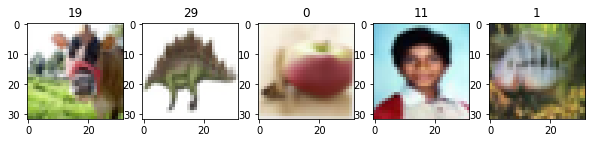

In [5]:
# 이미지 시각화하기
train_set = Dataset(train_x,train_y)
num_sample = 5

sample_x, sample_y = train_set.next_batch(num_sample)

fig = plt.figure(figsize=(10,3))
axes = fig.subplots(1,num_sample)

for ax, image, label in zip(axes, sample_x, sample_y):
    ax.set_title(label)
    ax.imshow(image)
plt.show()

<br>

# \[ 1. GoogLeNet  구성하기 \]
---
---


<br>

## 1. Inference Network 구성하기
---

* ImageNet에 비해 훨씬 이미지의 해상도 및 복잡도가 낮기 때문에,<br>
Filter의 크기를 전반적으로 2로 나누어 주겠습니다.
* 첫 레이어인 7x7 Conv Layer을 제거하고, 3x3 Conv Layer으로 변경하겠습니다.<br>

* CIFAR의 이미지를 처리할 수 있도록, Average Pooling Layer에서의 Pool과 Shape을 변경하도록 하겠습니다.<br>

In [6]:
def inception_module(prev_layer, 
                     one_conv_filters, 
                     reduced_three_filters,
                     three_conv_filters,
                     reduced_five_filters,
                     five_conv_filters,
                     after_pool_filters,
                     module_name='inception'):
    """
    Inception Module을 생성하는 메소드
    
    Arguments
    prev_layer : Input Layer
    one_conv_filters : 1x1 convolutions의 필터 갯수
    reduced_three_filters : 3x3 convolutions 앞에 있는 1x1 convolutions의 필터 갯수
    three_conv_filters : 3x3 convolutions의 필터 갯수
    reduced_five_filters : 5x5 convolutions 앞에 있는 1x1 convolutions의 필터 갯수
    file_conv_filters : 5x5 convolutions의 필터 갯수
    after_pool_filters : 3x3 max pool 이후 1x1 convolutions의 필터 갯수
    """
    he_init = tf.initializers.he_normal()
    with tf.variable_scope(module_name):
        out1 = tf.layers.Conv2D(one_conv_filters,(1,1),padding='SAME',
                                kernel_initializer=he_init,
                                activation=tf.nn.relu,name='1x1_conv')(prev_layer)
        
        out2 = tf.layers.Conv2D(reduced_three_filters, (1,1), padding='SAME',
                                kernel_initializer=he_init,
                                activation=tf.nn.relu, name='reduced_3x3')(prev_layer)
        out2 = tf.layers.Conv2D(three_conv_filters, (3,3), padding='SAME',
                                kernel_initializer=he_init,
                                activation=tf.nn.relu, name='3x3_conv')(out2)

        out3 = tf.layers.Conv2D(reduced_five_filters, (1,1), padding='SAME',
                                kernel_initializer=he_init,
                                activation=tf.nn.relu, name='reduced_5x5')(prev_layer)
        out3 = tf.layers.Conv2D(five_conv_filters, (5,5), padding='SAME',
                                kernel_initializer=he_init,
                                activation=tf.nn.relu, name='5x5_conv')(out3)
        
        out4 = tf.layers.MaxPooling2D((3,3),(1,1),padding='SAME',name='3x3_pool')(prev_layer)
        out4 = tf.layers.Conv2D(after_pool_filters, (1,1), padding='SAME',
                                kernel_initializer=he_init,
                                activation=tf.nn.relu, name='after_pool')(out4)
        
        out = tf.concat([out1,out2,out3,out4],axis=-1,name='filter_concatenation')
    return out

In [7]:
input_shape = (None,32,32,3)
num_classes = 100

graph = tf.Graph()
with graph.as_default():
    images = tf.placeholder(tf.float32, input_shape, name='images')
    is_train = tf.placeholder_with_default(False, (),name='is_train')
    
    with tf.variable_scope("preprocess"):
        image_mean = tf.constant([123.68, 116.779, 103.939], tf.float32)
        x = images - image_mean

    he_init = tf.initializers.he_uniform()
    xavier_init = tf.initializers.glorot_normal()    
    
    conv1 = tf.layers.Conv2D(32,(3,3),padding='SAME',
                             kernel_initializer=he_init,name='3x3_conv_1')(x)
    pool1 = tf.layers.MaxPooling2D((3,3),(2,2),padding='SAME',name='MaxPool_1')(conv1)

    conv2 = tf.layers.Conv2D(96,(3,3),padding='SAME',
                             kernel_initializer=he_init,name='3x3_conv_2')(pool1)
    pool2 = tf.layers.MaxPooling2D((3,3),(2,2),padding='SAME',name='MaxPool_2')(conv2)
    
    block_3a = inception_module(pool2,32,48,64,8,16,16,module_name='inception_3a')
    block_3b = inception_module(block_3a,64,64,96,16,48,32,module_name='inception_3b')
    pool3 = tf.layers.MaxPooling2D((3,3),(2,2),padding='SAME',name='MaxPool_3')(block_3b)    
    
    block_4a = inception_module(pool3,96,48,104,8,24,32,module_name='inception_4a')
    block_4b = inception_module(block_4a,80,56,112,12,32,32,module_name='inception_4b')
    block_4c = inception_module(block_4b,64,64,128,12,32,32,module_name='inception_4c')
    block_4d = inception_module(block_4c,56,72,144,16,32,32,module_name='inception_4d')    
    block_4e = inception_module(block_4d,128,80,160,16,64,64,module_name='inception_4e')        
    pool4 = tf.layers.MaxPooling2D((3,3),(2,2),padding='SAME',name='MaxPool_4')(block_4e)    
    
    block_5a = inception_module(pool4,128,80,160,16,64,64,module_name='inception_5a')
    block_5b = inception_module(block_5a,192,96,192,24,64,64,module_name='inception_5b')  
    
    # block_5b의 크기는 (?, 1, 1, 1024)으로 줄어듭니다.
    # 그러므로 Average Pooling Layer은 생략하도록 하겠습니다.
    avg_pool = tf.layers.Flatten()(block_5b)
    dropout = tf.layers.Dropout(rate=0.4)(avg_pool, training=is_train)
    fc = tf.layers.Dense(512, kernel_initializer=he_init,
                         activation=tf.nn.relu)(dropout)
    logits = tf.layers.Dense(num_classes,kernel_initializer=xavier_init)(fc)
    y_pred = tf.nn.softmax(logits)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
show_graph(graph)

<br>

## 2. 학습에 관련된 부분들 구성하기
---

* 논문과 동일하게 구현하도록 하겠습니다.<br>
* Auxiliary_network 부분의 Average Pooling Layer의 Pool Size와 Stride만<br>
변경하도록 하겠습니다.

### (1) Auxiliary Network 구성하기

In [9]:
with graph.as_default():
    with tf.variable_scope('auxiliary_network_4a'):
        # block_4a 의 shape는 (?, 4, 4, 256)이므로, 
        # Average Pooling 없이 적용하도록 하겠습니다.
        conv = tf.layers.Conv2D(64,(1,1),kernel_initializer=he_init,
                                activation=tf.nn.relu,name='1x1')(block_4a)
        fc = tf.layers.Flatten()(conv)
        fc = tf.layers.Dense(512,kernel_initializer=he_init,
                             activation=tf.nn.relu)(fc)
        fc = tf.layers.Dropout(0.7)(fc)
        aux_logit_4a = tf.layers.Dense(num_classes,
                                       kernel_initializer=xavier_init)(fc)
    
    with tf.variable_scope('auxiliary_network_4d'):
        # block_4d 의 shape는 (?, 4, 4, 264)이므로, 
        # Average Pooling 없이 적용하도록 하겠습니다.
        conv = tf.layers.Conv2D(64,(1,1),kernel_initializer=he_init,
                                activation=tf.nn.relu,name='1x1')(block_4d)
        fc = tf.layers.Flatten()(conv)
        fc = tf.layers.Dense(512,kernel_initializer=he_init,
                             activation=tf.nn.relu)(fc)
        fc = tf.layers.Dropout(0.7)(fc)
        aux_logit_4d = tf.layers.Dense(num_classes,
                                       kernel_initializer=xavier_init)(fc)

In [10]:
show_graph(graph)

### (2) Loss Function 구성하기

In [11]:
with graph.as_default():
    labels = tf.placeholder(tf.int64,shape=(None,),name='labels')
        
    with tf.variable_scope('losses'):
        main_loss = tf.losses.sparse_softmax_cross_entropy(labels,logits)
        aux_4a_loss = tf.losses.sparse_softmax_cross_entropy(labels, aux_logit_4a)
        aux_4d_loss = tf.losses.sparse_softmax_cross_entropy(labels, aux_logit_4d)
        loss = main_loss + 0.3 * aux_4a_loss + 0.3 * aux_4d_loss

Instructions for updating:
Use tf.cast instead.


### (3) Optimizer 구성하기

In [12]:
with graph.as_default():
    lr = tf.placeholder_with_default(1e-4,(),name='learning_rate')
    global_step = tf.train.get_or_create_global_step()
    
    train_op = (tf.train
                .MomentumOptimizer(learning_rate=lr,momentum=0.9)
                .minimize(loss,global_step=global_step))

### (4) Metric 구성하기

In [13]:
with graph.as_default():
    with tf.variable_scope('metrics'):
        top_5, top_5_op = tf.metrics.mean(
            tf.cast(tf.nn.in_top_k(logits, labels, k=5), tf.float32) * 100)
        top_1, top_1_op = tf.metrics.mean(
            tf.cast(tf.nn.in_top_k(logits, labels, k=1), tf.float32) * 100)
        metric_loss, loss_op = tf.metrics.mean(main_loss)
    
    # Total과 Count를 reset하는 연산자
    metric_init_op = tf.group([var.initializer for var in
                               graph.get_collection(tf.GraphKeys.METRIC_VARIABLES)],
                              name='metric_init_op')
    # Total과 Count를 갱신하는 연산자
    metric_update_op = tf.group([top_5_op, top_1_op, loss_op], 
                                name='metric_update_op')

    top_5 = tf.identity(top_5, name='top5_acc')
    top_1 = tf.identity(top_1, name='top1_acc')
    metric_loss = tf.identity(metric_loss, name='metric_loss')
    
    # Tensorboard에 기록할 정보 구성
    tf.summary.scalar('top5_accuracy', top_5)
    tf.summary.scalar('top1_accuracy', top_1)
    tf.summary.scalar('losses', metric_loss)    
    merged = tf.summary.merge_all()            

In [14]:
show_graph(graph)

<br>

# \[ 2. GoogleNet 학습하기 \]
---
---

> *CIFAR-100을 통해 모델을 학습시키도록 하겠습니다.*<br>

<br>

## 1. 모델 학습시키기
---


### (1) 데이터 셋 구성하기


In [15]:
(train_x, train_y), (test_x, test_y) = load_data()
train_y = train_y.reshape((-1,)) # (None, 1) -> (None, )
test_y = test_y.reshape((-1,)) # (None, 1) -> (None, )

train_set = Dataset(train_x,train_y)
test_set = Dataset(test_x,test_y)

### (2) Data Augmentation 적용하기

이전 Section에서 배웠던 몇 가지 Data Augmentation 기법을 활용해 보도록 하겠습니다.<br>

In [ ]:
def random_crop_and_pad(images,pad=4):
    """
    pad 크기만큼 무작위로 위아래, 좌우로 움직이는 메소드
    """
    _, h, w, _ = images.shape
    pad_images = np.pad(images,[(0,0),(pad,pad),(pad,pad),(0,0)],
                        mode='constant')
    
    crops = []
    for idx, image in enumerate(pad_images):
        start_y = np.random.randint(0,pad)
        start_x = np.random.randint(0,pad)
        cropped = image[start_y:start_y+h,
                        start_x:start_x+w]
        crops.append(cropped)
    return np.stack(crops)

def random_flip_left_right(images):
    """
    무작위로 이미지를 좌우로 뒤집어 주는 메소드    
    """
    for idx, image in enumerate(images):
        if np.random.random() > 0.5:
            images[idx] = image[:,::-1]
    return images

In [ ]:
def augment_images(images):
    """
    평행이동 -> 뒤집기 변환을 거쳐 데이터에 노이즈를 주는 메소드
    """
    images = random_crop_and_pad(images, pad=4)
    images = random_flip_left_right(images)
    return images

In [ ]:
image = train_x[0]

samples = np.stack([image]*12)
aug_images = augment_images(samples)

fig = plt.figure(figsize=(10,3))
for idx, image in enumerate(aug_images,1):
    ax = fig.add_subplot(3,4,idx)
    ax.imshow(image)
plt.show()

### (3) 학습과정을 기록할 Tensorboard 구성하기

In [ ]:
# LOG PATH Setting
LOG_DIR = "./log"
if os.path.exists(LOG_DIR):
    shutil.rmtree(LOG_DIR)
os.makedirs(LOG_DIR,exist_ok=True)

tbc = tensorboardcolab.TensorBoardColab(graph_path=LOG_DIR)

train_writer = tf.summary.FileWriter(LOG_DIR+"/train", graph)
test_writer = tf.summary.FileWriter(LOG_DIR+"/test")

### (4) 세션 초기화하기

In [17]:
# 변수 초기화 및 Operation 가져오기
sess = tf.Session(graph=graph)
with graph.as_default():
    sess.run([tf.global_variables_initializer(),
              tf.local_variables_initializer()])

### (5) 모델 학습하기 

In [18]:
num_epoch = 100
num_batch = 128
num_data = len(train_set)

for epoch in range(num_epoch):
    # Fitting Model  
    for step in tqdm(range(num_data//num_batch)):
        batch_x, batch_y = train_set.next_batch(num_batch)
        batch_x = augment_images(batch_x)        
        sess.run(train_op,feed_dict={
            images: batch_x,
            labels: batch_y,
            is_train:True})
    # Shuffle Dataset
    train_set.shuffle()
    
    # Summarize training process
    sess.run(metric_init_op)
    for step in range(0,len(train_set)//1000):
        # 1000개씩 나누어서 metric을 계산합니다.
        batch_x = train_x[step*1000:(step+1)*1000]
        batch_y = train_y[step*1000:(step+1)*1000].ravel()
        sess.run(metric_update_op,feed_dict={images:batch_x,
                                             labels:batch_y})
    
    summary, top_1_value, top_5_value = sess.run(
        [merged,top_1,top_5], feed_dict={images:batch_x,
                                         labels:batch_y})
    
    print("[{:3d} epoch] TRAIN TOP-1 ACC : {:2.2f}% | TOP-5 ACC : {:2.2f}%"
          .format(epoch, top_1_value,top_5_value))
    train_writer.add_summary(summary, global_step.eval(sess))

    sess.run(metric_init_op)
    for step in range(len(test_set)//1000):
        batch_x = test_x[step*1000:(step+1)*1000]
        batch_y = test_y[step*1000:(step+1)*1000].ravel()
        sess.run(metric_update_op,feed_dict={images:batch_x,
                                             labels:batch_y})
        
    summary, top_1_value, top_5_value = sess.run(
        [merged,top_1,top_5], feed_dict={images:batch_x,
                                         labels:batch_y})
    print("[{:3d} epoch] TEST TOP-1 ACC : {:2.2f}% | TOP-5 ACC : {:2.2f}%"
          .format(epoch, top_1_value,top_5_value))
    test_writer.add_summary(summary, global_step.eval(sess))
    

100%|██████████| 390/390 [03:21<00:00,  1.93it/s]


[  0 epoch] TRAIN TOP-1 ACC : 0.00% | TOP-5 ACC : 0.00% | LOSS : nan


NameError: name 'train_writer' is not defined

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/05/13

---